In [1]:
# Step 0. Load libraries and custom functions
# Matrices and datasets ------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Text processors
import re
import string
from wordcloud import WordCloud
# Machine Learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
# Deep Learning --------------------------------------------------------
import keras
import tensorflow as tf
from keras import layers
from keras.layers import TextVectorization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Custom functions -----------------------------------------------------
def sentence_fixed_split(x:list, words: int):
    """
    Split a list of sentences into a list of fixed length sentences.
    param x: sentence as a list of words
    param words: number of fixed words required
    return: list of fixed length sentences
    """
    words_lenght = len(x.split(' '))
    if words_lenght>1 and words > 1 and words_lenght > words:
        return [' '.join(x.split(' ')[i:i+words]) for i in range(0, len(x.split(' ')), words)]
    else:
        return x

In [2]:
# Step 1. Load data
# 1.1 Read csv and get basic info
df_raw = pd.read_csv('../data/01_IMDB_Dataset_HuggingFace.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [3]:
# 1.2 Get a sample
df_raw.sample(10, random_state=2024)

,review,sentiment
16441,"Like most musicals of the era, one must check ...",negative
26819,I saw this show about 3-4 years ago. It was da...,positive
9242,"One of, if not THE most visually beautiful fil...",positive
16234,Although this lovely work of art does use some...,positive
19184,Don't waste your time or money on this one. Th...,negative
34763,"Twelve Monkeys is an insane time-travelling, a...",positive
36781,Just when you thought it was safe to go back i...,negative
9082,at first i thought it was bad because i had gr...,negative
39944,"I wouldn't exactly call this a good movie, in ...",negative
38247,"This movie is very bad. In fact, the only reas...",negative


In [4]:
# 1.3 Verify if there are duplicates
df_raw['review'].duplicated().sum()

418

In [5]:
# 1.4 Preprocess data based on observed information
df_interim = df_raw.copy()
df_interim = df_interim[~df_interim.review.duplicated()]
df_interim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [6]:
# 1.5 Create the final dataframe
df_final = df_interim.copy()

In [7]:
# 1.6 Create your train, validation and test datasets
test_split = 0.3
val_split = 0.5
train_df, test_df = train_test_split(
    df_final,
    test_size=test_split,
    stratify=df_final['sentiment'].values,
    random_state=2024
)

val_df = test_df.sample(frac=val_split)
test_df = test_df.drop(val_df.index)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [8]:
# Step 2. Create a basic analysis
# 2.1 Get basic info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34707 entries, 0 to 34706
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     34707 non-null  object
 1   sentiment  34707 non-null  object
dtypes: object(2)
memory usage: 542.4+ KB


In [9]:
# 2.2 Get a summary of the data
train_df.describe(include='all')

,review,sentiment
count,34707,34707
unique,34707,2
top,The plot - in the future when nearly all men h...,positive
freq,1,17419


In [10]:
# 2.3 Get words statistics
train_df['review'].apply(lambda x: len(x.split())).describe()

count    34707.000000
mean       231.663036
std        172.210101
min          4.000000
25%        126.000000
50%        173.000000
75%        281.000000
max       2470.000000
Name: review, dtype: float64

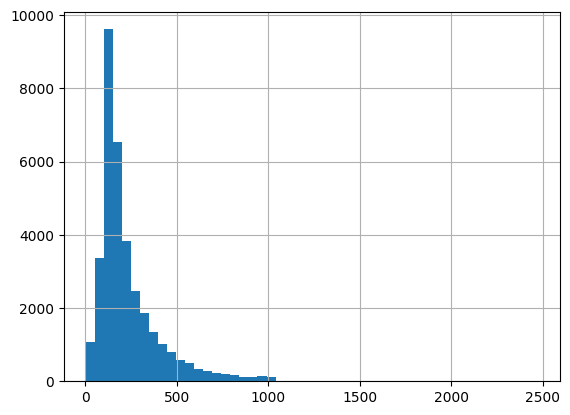

In [11]:
# 2.4 Show histogram of word count
train_df['review'].apply(lambda x: len(x.split(' '))).hist(bins=50)
plt.show()

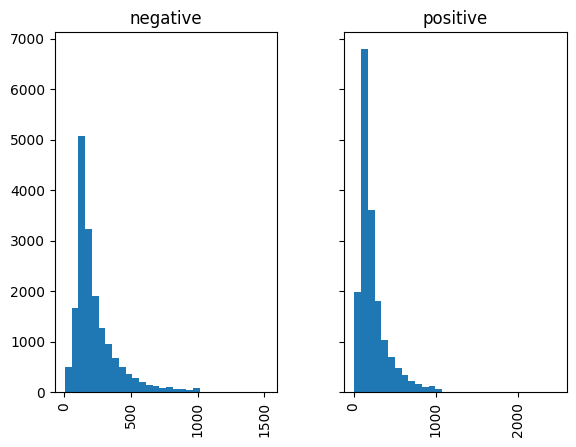

In [12]:
# 2.5 Show histogram of word count stratified by sentiment
(train_df
 .assign(word_count = train_df['review'].apply(lambda x: len(x.split())))
 .hist('word_count', by='sentiment', grid=True, sharey=True, bins=30)
)
plt.show()

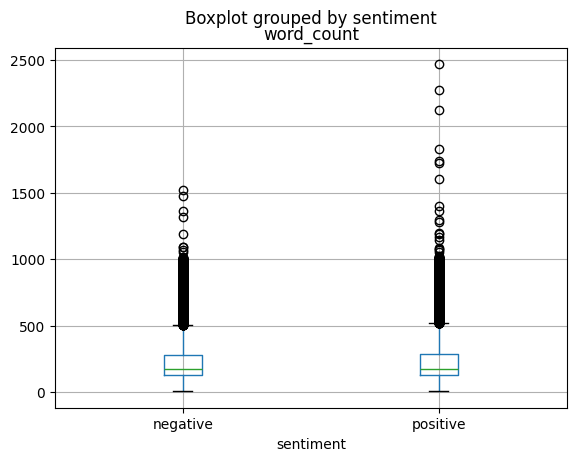

In [13]:
# 2.6 Show boxplot of word count stratified by sentiment
(train_df
 .assign(word_count = train_df['review'].apply(lambda x: len(x.split())))
 .boxplot('word_count', by='sentiment')
)
plt.show()

In [14]:
# 2.7 List total words in our vocabulary
train_df['review'].str.split(expand=True).stack().value_counts().count()

350557

In [15]:
# 2.8 List most frequent words in reviews
train_df['review'].str.split(expand=True).stack().value_counts()[:20]

the      395852
a        213585
and      210012
of       197593
to       182011
is       141795
in       118405
I         91558
that      88042
this      78995
it        75092
/><br     70559
was       64114
as        57623
with      57437
for       56220
The       46736
but       45908
on        42657
movie     42277
Name: count, dtype: int64

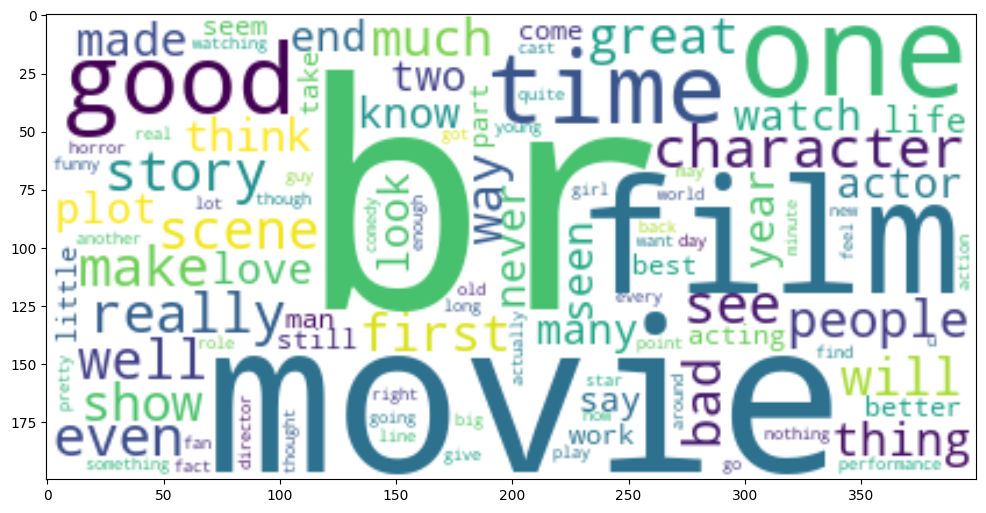

In [16]:
# 2.9 View the wordcloud of reviews without stopwords
text = ' '.join(i.lower() for i in train_df['review'])
wordcloud = WordCloud(max_words=100, 
                      stopwords=None, 
                      background_color='White', 
                      collocations=False).generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()


After analyzing the dataset, we need to create a processing pipeline that:
- removes stopwords
- removes html tags
- removes punctuations
- uses a compact vocabulary
- lowercases the words
- corrects mispelled words like soooo, muuuuch, etc (more than 3 vowels)
- encode sentiment into 1 or 0 

For our traning task, we can split longest reviews into segments or just 
truncate the review up to 500 words and eliminate the rest, but it 
results in losing some information, so we will try both aproaches

In [30]:
# Step 3. Train and execute model iter 1.
# Create a copy
train_ds    = train_df.copy()
val_ds      = val_df.copy()
test_ds     = test_df.copy()
# Encode sentiment response variable
train_ds['sentiment']   = train_ds['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
val_ds['sentiment']     = val_ds['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
test_ds['sentiment']    = test_ds['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
# Tokenize words on the dataset
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_ds['review'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_ds['review'])
padded_sequences_train = pad_sequences(sequences, maxlen=200, truncating='post')
sequences = tokenizer.texts_to_sequences(val_ds['review'])
padded_sequences_val = pad_sequences(sequences, maxlen=200, truncating='post')
sequences = tokenizer.texts_to_sequences(test_ds['review'])
padded_sequences_test = pad_sequences(sequences, maxlen=200, truncating='post')
# Create model
inputs = keras.Input(shape=(200,))
x = layers.Dense(26, activation='relu')(inputs)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
model.summary()
model.fit(padded_sequences_train, train_ds['sentiment'], epochs=10, batch_size=32, validation_data=(padded_sequences_val, val_ds['sentiment']))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_6 (Dense)             (None, 26)                5226      
                                                                 
 dropout_3 (Dropout)         (None, 26)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 27        
                                                                 
Total params: 5253 (20.52 KB)
Trainable params: 5253 (20.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


2024-02-22 22:08:25.884142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1085/1085 [==============================] - 14s 12ms/step - loss: 872.0229 - accuracy: 0.4943 - val_loss: 94.5752 - val_accuracy: 0.5004
Epoch 2/10
1085/1085 [==============================] - 12s 11ms/step - loss: 29.0425 - accuracy: 0.5010 - val_loss: 22.5144 - val_accuracy: 0.5024
Epoch 3/10
1085/1085 [==============================] - 13s 12ms/step - loss: 10.6020 - accuracy: 0.5001 - val_loss: 10.8022 - val_accuracy: 0.4962
Epoch 4/10
1085/1085 [==============================] - 12s 11ms/step - loss: 9.4605 - accuracy: 0.5038 - val_loss: 10.0040 - val_accuracy: 0.4993
Epoch 5/10
1085/1085 [==============================] - 12s 11ms/step - loss: 9.1521 - accuracy: 0.5027 - val_loss: 6.5745 - val_accuracy: 0.5008
Epoch 6/10
1085/1085 [==============================] - 13s 12ms/step - loss: 9.2828 - accuracy: 0.5027 - val_loss: 6.1857 - val_accuracy: 0.5013
Epoch 7/10
1085/1085 [==============================] - 13s 12ms/step - loss: 9.1610 - accuracy: 0.4981 - val_loss: 10.5883 - v

In [ ]:
keras.utils.

In [32]:
padded_sequences_train.shape

(34707, 200)

["stupid'",
 'taximeter',
 'blodgett',
 'thickening',
 "apache'",
 "ribbon'",
 'mormom',
 "shiloh's",
 'showmen',
 'mormoms',
 "kemper's",
 "ritchie'",
 "'guy",
 'legoinairre',
 'handcart',
 "don't's",
 'briggitta',
 'vinterkriget',
 'agonies',
 'frizzed',
 "shuddery'n'spooky",
 'cordio',
 "battaglia's",
 'gianlorenzo',
 "laurenti's",
 'excitied',
 'citycenter',
 'oleson',
 "nurses'",
 'portmanteaux',
 "cybele'",
 "'si",
 'starfishes',
 "l'étoile",
 'tsanders',
 'pastors',
 "'christiany'",
 'linchpins',
 'subscript',
 'dishrag',
 "mutineers'",
 'demarol',
 'broadus',
 'pleeeeease',
 'irm',
 'hirschmuller',
 "hans'",
 'showtim',
 'fooledtons',
 'tonorma',
 "intruders'",
 'frissons',
 'loosers',
 '576',
 'aghhh',
 'lilli',
 'desicion',
 'jeepster',
 "marc's",
 'murrayest',
 'kissless',
 'marys',
 'basgallop',
 'sives',
 'emigrants',
 'trafficked',
 'defenitly',
 'rstj',
 'overcranked',
 'itinerary',
 'koya',
 'badboys',
 'bathgate',
 'kerosine',
 'smelt',
 'franziska',
 'alloyed',
 'nand

In [ ]:
# 1.3 Preprocess data in order to avoid html tags and show result
# df_interim = df_raw.copy()
# # Get original lenght of words
# df_interim['original_len'] = df_interim['review'].apply(lambda x: len(x.split(' '))) 
# # Supress html tags
# df_interim['user_review'] = df_interim['review'].str.replace(r'(<.*?>)','',regex=True)
# # In case of many white spaces, replace with only one white space
# df_interim['user_review'] = df_interim['user_review'].str.replace(r'\s+',' ',regex=True)
# # In case of a space followed by a comma, replace with a comma followed by a space
# df_interim['user_review'] = df_interim['user_review'].str.replace(r'\s,\s',', ',regex=True)
# # Replace backslashes
# df_interim['user_review'] = df_interim['user_review'].str.replace(r'\\','',regex=True)
# # In case of three or more consecutive letters, replace with only two or less consecutive letters
# df_interim['user_review'] = df_interim['user_review'].str.replace(r'([a-zA-Z])\1{2,}', r'\1', regex=True)
# # Strip white spaces at the beginning and at the end of the review
# df_interim['user_review'] = df_interim['user_review'].str.strip()
# # Convert labels into integers
# df_interim['label'] = df_interim['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
# # Drop duplicates
# df_interim = df_interim.drop_duplicates()
# # There's a particular repeated row
# df_interim = df_interim.drop([44855],axis=0)
# # Apply custom function to split long sentences into more 
# df_interim['reviews'] = df_interim['user_review'].apply(lambda x: sentence_fixed_split(x,1000))
# df_interim = df_interim.explode('reviews')

In [ ]:
# Step 3. Create the deep learning model 
# 3.1 Prepare data to encode dependent variable as a numeric
train_df['sentiment'] = train_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
val_df['sentiment'] = val_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
test_df['sentiment'] = test_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_ds = tf.data.Dataset.from_tensor_slices((
    tf.cast(train_df['review'], tf.string),
    tf.cast(train_df['sentiment'], tf.int32)
))

val_ds = tf.data.Dataset.from_tensor_slices((
    tf.cast(val_df['review'], tf.string),
    tf.cast(val_df['sentiment'], tf.int32)
))

test_ds = tf.data.Dataset.from_tensor_slices((
    tf.cast(test_df['review'], tf.string),
    tf.cast(test_df['sentiment'], tf.int32)
))


In [ ]:
# 3.2 Create custom functions for strings on the model pipeline
def custom_standardization_fn(string_tensor):
    stripped_string = tf.strings.strip(string_tensor)
    lowercase_string = tf.strings.lower(stripped_string)
    tagless_string = tf.strings.regex_replace(lowercase_string, '<.*?>', '')
    single_space_string = tf.strings.regex_replace(tagless_string, '\s+',' ')
    comma_space_string = tf.strings.regex_replace(single_space_string, '\s,\s',', ')
    simple_vowel_a_string = tf.strings.regex_replace(comma_space_string, 'a{3,}', 'a')
    simple_vowel_e_string = tf.strings.regex_replace(simple_vowel_a_string, 'e{3,}', 'e')
    simple_vowel_i_string = tf.strings.regex_replace(simple_vowel_e_string, 'i{3, }', 'i')
    simple_vowel_o_string = tf.strings.regex_replace(simple_vowel_i_string, 'o{3, }', 'o')
    simple_vowel_u_string = tf.strings.regex_replace(simple_vowel_o_string, 'u{3, }', 'u')
    stripped_string_again = tf.strings.strip(simple_vowel_u_string)
    return tf.strings.regex_replace(stripped_string_again,
                                    f"[{re.escape(string.punctuation)}]",'')
    
def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor)

In [ ]:
# 3.3 Create the text vectorizer and apply to the data splits
MAX_VOCAB = 20000
MAX_LENGTH = 500
BATCH_SIZE = 32

text_vectorizer = TextVectorization(
    max_tokens=MAX_VOCAB,
    standardize=custom_standardization_fn,
    split=custom_split_fn,
    output_mode='multi_hot'
)

text_vectorizer.adapt(train_df.review.values)
X_train = text_vectorizer(train_df.review.values)
X_val = text_vectorizer(val_df.review.values)
X_test = text_vectorizer(test_df.review.values)
y_train = tf.convert_to_tensor(train_df.sentiment.values)
y_val = tf.convert_to_tensor(val_df.sentiment.values)
y_test = tf.convert_to_tensor(test_df.sentiment.values)


In [ ]:
vocab = text_vectorizer.get_vocabulary()

In [ ]:
def get_model(max_tokens=MAX_VOCAB, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
model = get_model()
model.summary()

In [ ]:
model.fit(x=X_train,
          y=y_train,
          epochs=10)

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# Load the IMDB dataset from CSV
data_path = '../data/01_IMDB_Dataset_HuggingFace.csv'  # Replace with the actual path
df = pd.read_csv(data_path)

# Preprocess the data
max_length = 256
X = df['review'].values
y = df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize and pad sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_length)

# Define the model architecture
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=10000, output_dim=16)(input_layer)
average_pooling_layer = GlobalAveragePooling1D()(embedding_layer)
dense_layer = Dense(16, activation='relu')(average_pooling_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
